**TFM - Latent space comparison between different generative models (VAE, GAN, StyleGAN...)**

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

------------------------------------------
**GAN**

Parameters

In [49]:
# Parameters
class Options:
    n_epochs = 100
    batch_size = 64
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    n_cpu = 8
    latent_dim = 2
    img_size = 28
    channels = 1
    sample_interval = 100

opt = Options()

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False



**Generator and Discriminator architecture**

In [50]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Loss function

In [51]:
# Loss function
adversarial_loss = torch.nn.BCELoss()


Initialization

In [52]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

Load data

In [53]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

Optimizers

In [54]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Lists to store the losses
g_losses = []
d_losses = []

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Training

In [55]:
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

[Epoch 0/100] [Batch 0/938] [D loss: 0.726593] [G loss: 0.725697]
[Epoch 0/100] [Batch 1/938] [D loss: 0.641149] [G loss: 0.721706]
[Epoch 0/100] [Batch 2/938] [D loss: 0.571608] [G loss: 0.718207]
[Epoch 0/100] [Batch 3/938] [D loss: 0.515865] [G loss: 0.713249]
[Epoch 0/100] [Batch 4/938] [D loss: 0.464288] [G loss: 0.708295]
[Epoch 0/100] [Batch 5/938] [D loss: 0.431157] [G loss: 0.700183]
[Epoch 0/100] [Batch 6/938] [D loss: 0.407203] [G loss: 0.689792]
[Epoch 0/100] [Batch 7/938] [D loss: 0.397797] [G loss: 0.671650]
[Epoch 0/100] [Batch 8/938] [D loss: 0.396995] [G loss: 0.652641]
[Epoch 0/100] [Batch 9/938] [D loss: 0.410595] [G loss: 0.618678]
[Epoch 0/100] [Batch 10/938] [D loss: 0.429340] [G loss: 0.582626]
[Epoch 0/100] [Batch 11/938] [D loss: 0.462983] [G loss: 0.531876]
[Epoch 0/100] [Batch 12/938] [D loss: 0.502337] [G loss: 0.485763]
[Epoch 0/100] [Batch 13/938] [D loss: 0.519828] [G loss: 0.469869]
[Epoch 0/100] [Batch 14/938] [D loss: 0.539383] [G loss: 0.457361]
[Epoc

Loss curve

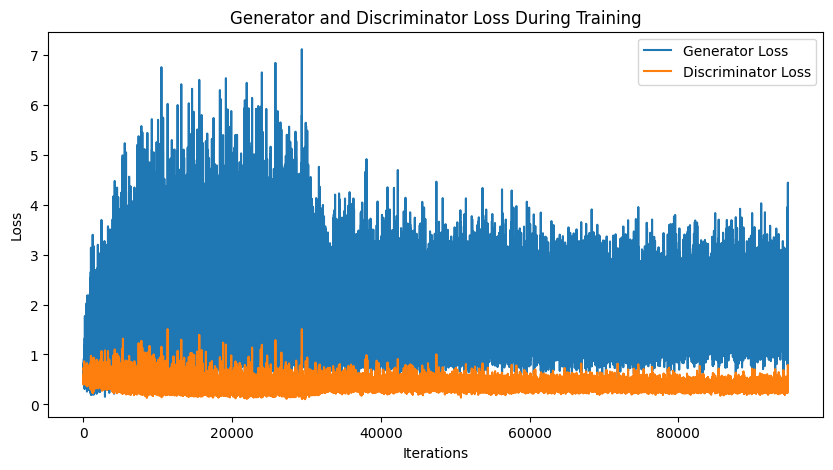

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Generator and Discriminator Loss During Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


Visualization of generated images

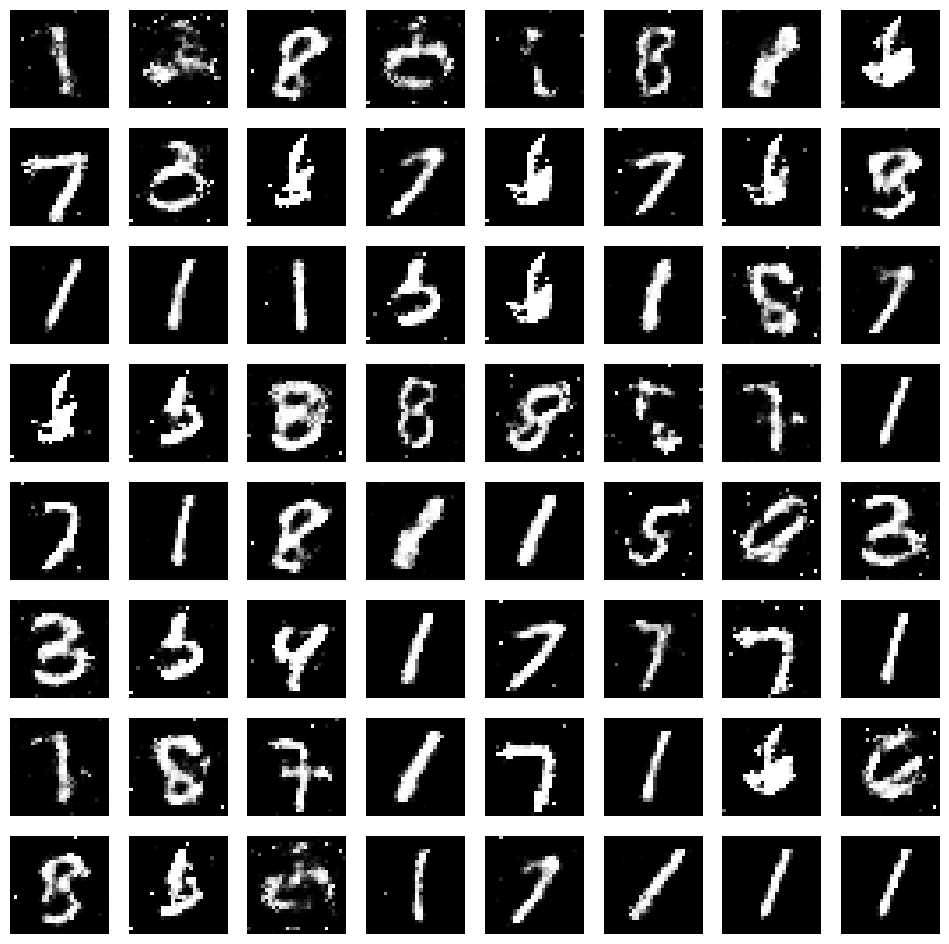

In [57]:
import matplotlib.pyplot as plt

# Define latent size and batch size
latent_size = opt.latent_dim
batch_size = 64

# Generate fixed noise for latent space visualization
fixed_noise = torch.randn(batch_size, latent_size)
if cuda:
    fixed_noise = fixed_noise.cuda()

# Generate fake images from the fixed latent space
fake_images = generator(fixed_noise)

# Convert fake images to numpy array
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], opt.img_size, opt.img_size)

# Visualize the generated images
R, C = 8, 8
fig = plt.figure(figsize=(12, 12))

for i in range(batch_size):
    axes = fig.add_subplot(R, C, i + 1)
    axes.imshow(fake_images_np[i], cmap='gray')
    axes.set_axis_off()

plt.show()


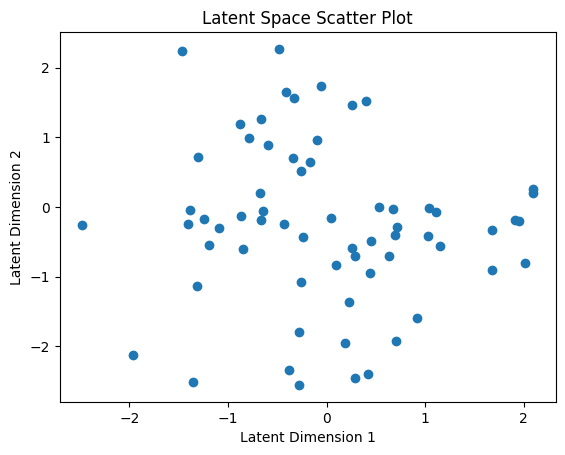

In [58]:
# Scatter plot of latent space
plt.scatter(fixed_noise[:, 0].cpu().numpy(), fixed_noise[:, 1].cpu().numpy())
plt.title("Latent Space Scatter Plot")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


Visualization of latent space

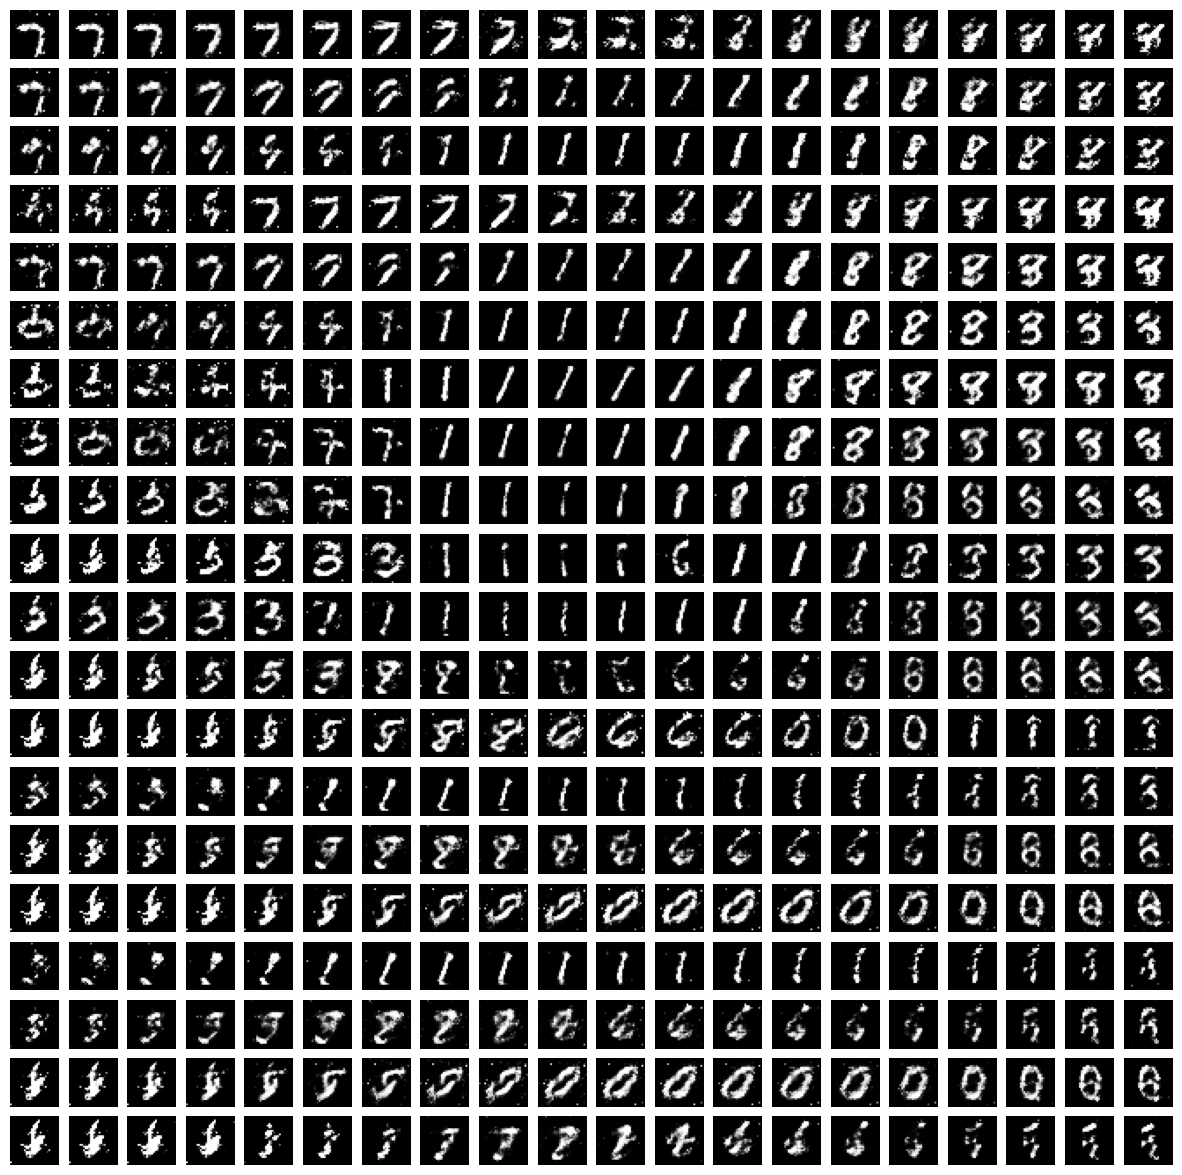

In [70]:
if cuda:
    myspace = myspace.cuda()
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Generate images from the grid of latent vectors
with torch.no_grad():
    generated_imgs = []
    for i in range(0, len(myspace), batch_size):
        # Adjust batch size for the last iteration if there are fewer points left
        current_batch_size = min(batch_size, len(myspace) - i)
        
        # Create a noise vector with the adjusted batch size
        z = torch.randn(current_batch_size, latent_size).to(myspace.device)
        
        # Assign the corresponding points from myspace to the first 2 dimensions of z
        z[:, :2] = myspace[i:i+current_batch_size]
        
        # Generate images from the latent space points
        generated_imgs.append(generator(z))

# Visualize the generated images from the latent space grid
fig = plt.figure(figsize=(15, 15))

# Flatten generated_imgs and visualize
generated_imgs = torch.cat(generated_imgs)

for i, img in enumerate(generated_imgs):
    axes = fig.add_subplot(20, 20, i + 1)
    axes.imshow(img[0].cpu().numpy(), cmap='gray')
    axes.set_axis_off()

plt.show()


-------------------------------------------------------------------------------
**Latent Space Inversion Using a CNN**

1. Define the Inverter (Encoder)

In [79]:
class Inverter(nn.Module):
    def __init__(self, latent_dim):
        super(Inverter, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: (512, 2, 2)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, latent_dim)  # Correct input size to Linear layer
        )
    
    def forward(self, img):
        z = self.encoder(img)
        return z
